In [1]:
import os
import boto3
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
load_dotenv()

True

In [3]:
# Custom function to reduce memory usage of data

def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
AWS_S3_BUCKET = os.getenv("AWS_S3_BUCKET")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

In [5]:
s3_client = boto3.client(
    "s3",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)

response = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key="processed/tcga_processed.csv")

status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

if status == 200:
    print(f"Successful S3 get_object response. Status - {status}")
    df = reduce_mem_usage(pd.read_csv(response.get("Body")))
    print(df.info())
else:
    print(f"Unsuccessful S3 get_object response. Status - {status}")

Successful S3 get_object response. Status - 200
Mem. usage decreased to  0.81 Mb (86.3% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11912 entries, 0 to 11911
Data columns (total 65 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Primary_Site                    11912 non-null  int8   
 1   Deceased_Status                 11912 non-null  int8   
 2   Age_At_Diagnosis                11817 non-null  float32
 3   Prior_Malignancy                11912 non-null  int8   
 4   Synchronous_Malignancy          11912 non-null  int8   
 5   TP53                            11912 non-null  int8   
 6   PIK3CA                          11912 non-null  int8   
 7   TTN                             11912 non-null  int8   
 8   CDH1                            11912 non-null  int8   
 9   GATA3                           11912 non-null  int8   
 10  APC                             11912 non-null  int8   

In [6]:
final_df = df.drop('Weight', axis=1)

In [7]:
final_df.head()

,Primary_Site,Deceased_Status,Age_At_Diagnosis,Prior_Malignancy,Synchronous_Malignancy,TP53,PIK3CA,TTN,CDH1,GATA3,...,HRAS,KMT2D,BTG2,B2M,PIM1,IGHG1,Race_asian,Race_black or african american,Race_other,Race_white
0,0,0,9.602739,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,6.375342,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,16.753426,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,16.038357,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,14.052054,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
final_df.shape

(11912, 64)

## Distribution of target classes

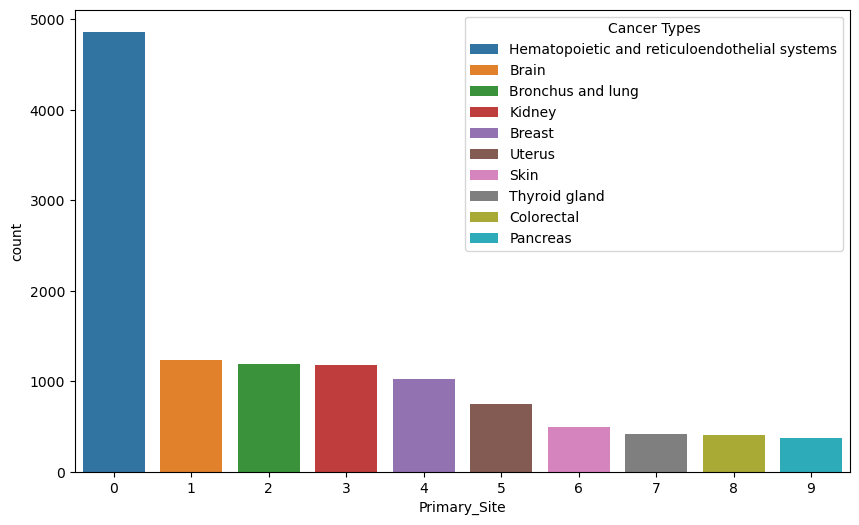

In [9]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data = final_df, x = 'Primary_Site', hue='Primary_Site', dodge=False)
h,l = ax.get_legend_handles_labels()
labels=['Hematopoietic and reticuloendothelial systems', 
                   'Brain',
                   'Bronchus and lung',
                   'Kidney',
                   'Breast',
                   'Uterus', 
                   'Skin', 
                   'Thyroid gland', 
                   'Colorectal',
                   'Pancreas']
ax.legend(h,labels,title="Cancer Types", loc="upper right") 
plt.show()

As demonstrated in the plot above, the classes have a severe imbalance problem, especially for class 0 which pertains to Myeloid cancers. Therefore, the weight column is used to address the imbalance in the model.

## Distributions of target classes by age at diagnosis

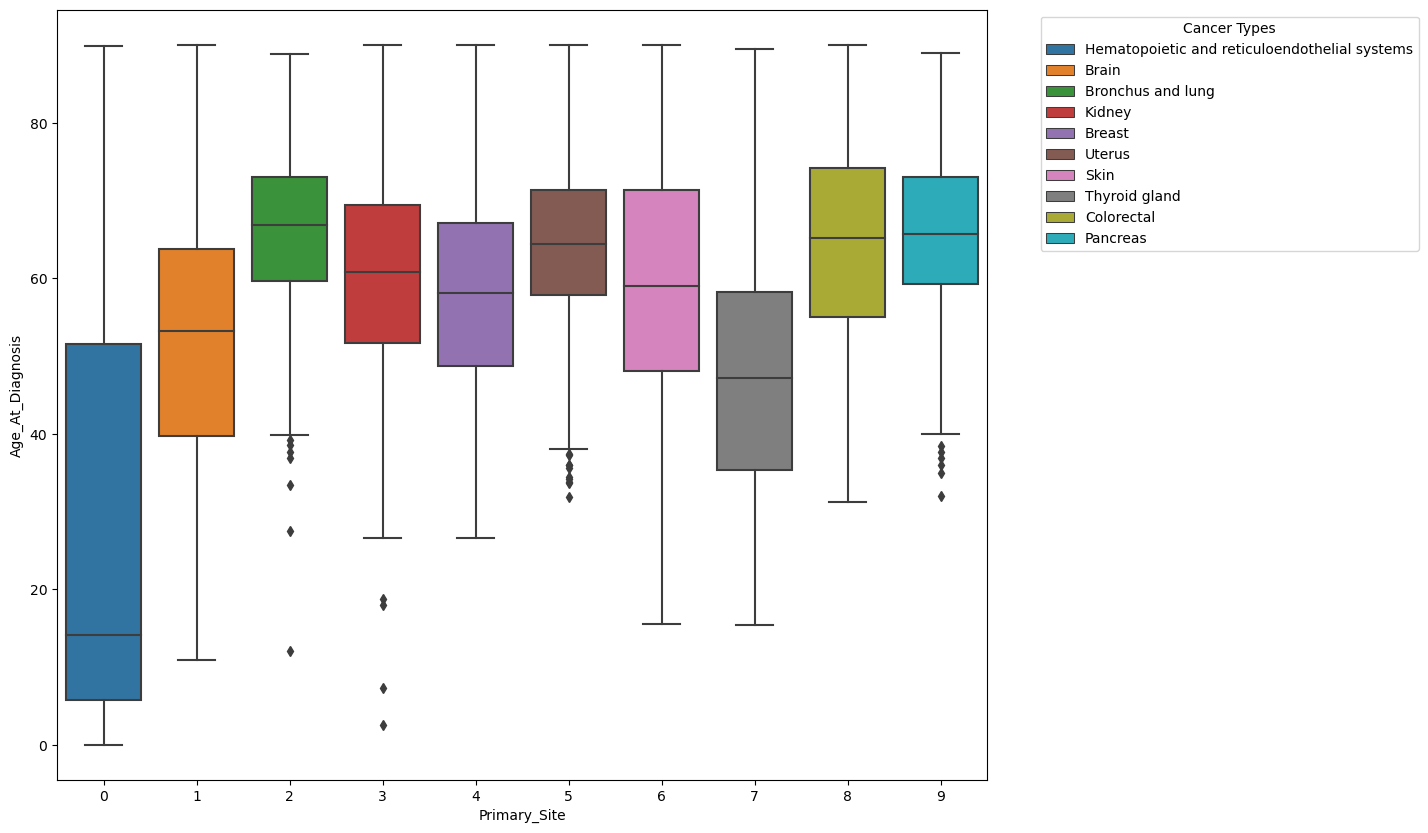

In [10]:
plt.figure(figsize=(12,10))
ax = sns.boxplot(data = final_df, x = 'Primary_Site', y='Age_At_Diagnosis', hue='Primary_Site', dodge=False)
h,l = ax.get_legend_handles_labels()
labels=['Hematopoietic and reticuloendothelial systems', 
                   'Brain',
                   'Bronchus and lung',
                   'Kidney',
                   'Breast',
                   'Uterus', 
                   'Skin', 
                   'Thyroid gland', 
                   'Colorectal',
                   'Pancreas']
ax.legend(h,labels,title="Cancer Types", bbox_to_anchor= (1.05,1))
plt.show()

## Correlation heat map for multicollinearity

In [11]:
final_df.corr()

,Primary_Site,Deceased_Status,Age_At_Diagnosis,Prior_Malignancy,Synchronous_Malignancy,TP53,PIK3CA,TTN,CDH1,GATA3,...,HRAS,KMT2D,BTG2,B2M,PIM1,IGHG1,Race_asian,Race_black or african american,Race_other,Race_white
Primary_Site,1.000000,0.136064,0.490201,0.123976,0.010351,0.280266,0.221857,0.276694,0.093996,0.088017,...,0.072637,0.164602,-0.008229,0.073104,0.001771,0.060709,0.034998,-0.003073,0.056133,-0.039743
Deceased_Status,0.136064,1.000000,0.272575,0.044180,-0.013513,0.141070,-0.002126,0.106704,-0.017061,-0.001712,...,0.008920,0.030123,-0.008012,0.007862,-0.017044,0.028656,-0.027354,-0.046962,0.023928,0.044223
Age_At_Diagnosis,0.490201,0.272575,1.000000,0.166860,0.032859,0.284029,0.180075,0.324293,0.084329,0.072330,...,0.043550,0.149766,0.036444,0.055768,0.049969,0.072308,-0.016898,-0.008307,0.026364,0.006352
Prior_Malignancy,0.123976,0.044180,0.166860,1.000000,-0.011249,0.066159,0.043865,0.076260,0.033055,0.009052,...,0.015794,0.026528,0.016563,0.001229,0.008050,0.024613,-0.035088,0.011645,-0.032318,0.023853
Synchronous_Malignancy,0.010351,-0.013513,0.032859,-0.011249,1.000000,0.013860,-0.015472,0.020012,0.004896,0.015884,...,-0.003590,0.001017,-0.003021,0.014371,-0.003750,0.010946,-0.012683,0.044582,-0.007981,-0.024843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IGHG1,0.060709,0.028656,0.072308,0.024613,0.010946,0.033760,0.018011,0.114111,0.024982,0.041850,...,0.018330,0.064441,0.098602,0.041781,0.053037,1.000000,0.002231,-0.017373,-0.015081,0.018262
Race_asian,0.034998,-0.027354,-0.016898,-0.035088,-0.012683,0.051633,-0.005086,-0.006714,-0.010318,0.006627,...,0.010831,0.016643,0.024973,0.005636,0.014159,0.002231,1.000000,-0.082282,-0.036437,-0.510433
Race_black or african american,-0.003073,-0.046962,-0.008307,0.011645,0.044582,0.019150,0.017323,-0.019466,0.005363,0.018027,...,0.009070,-0.010759,-0.009997,-0.009726,0.002785,-0.017373,-0.082282,1.000000,-0.051777,-0.725332
Race_other,0.056133,0.023928,0.026364,-0.032318,-0.007981,0.024298,0.020604,0.012749,-0.007671,-0.008809,...,-0.001947,0.022181,-0.008678,0.007183,0.021270,-0.015081,-0.036437,-0.051777,1.000000,-0.321196


Text(0.5, 1.0, 'Correlation Heatmap')

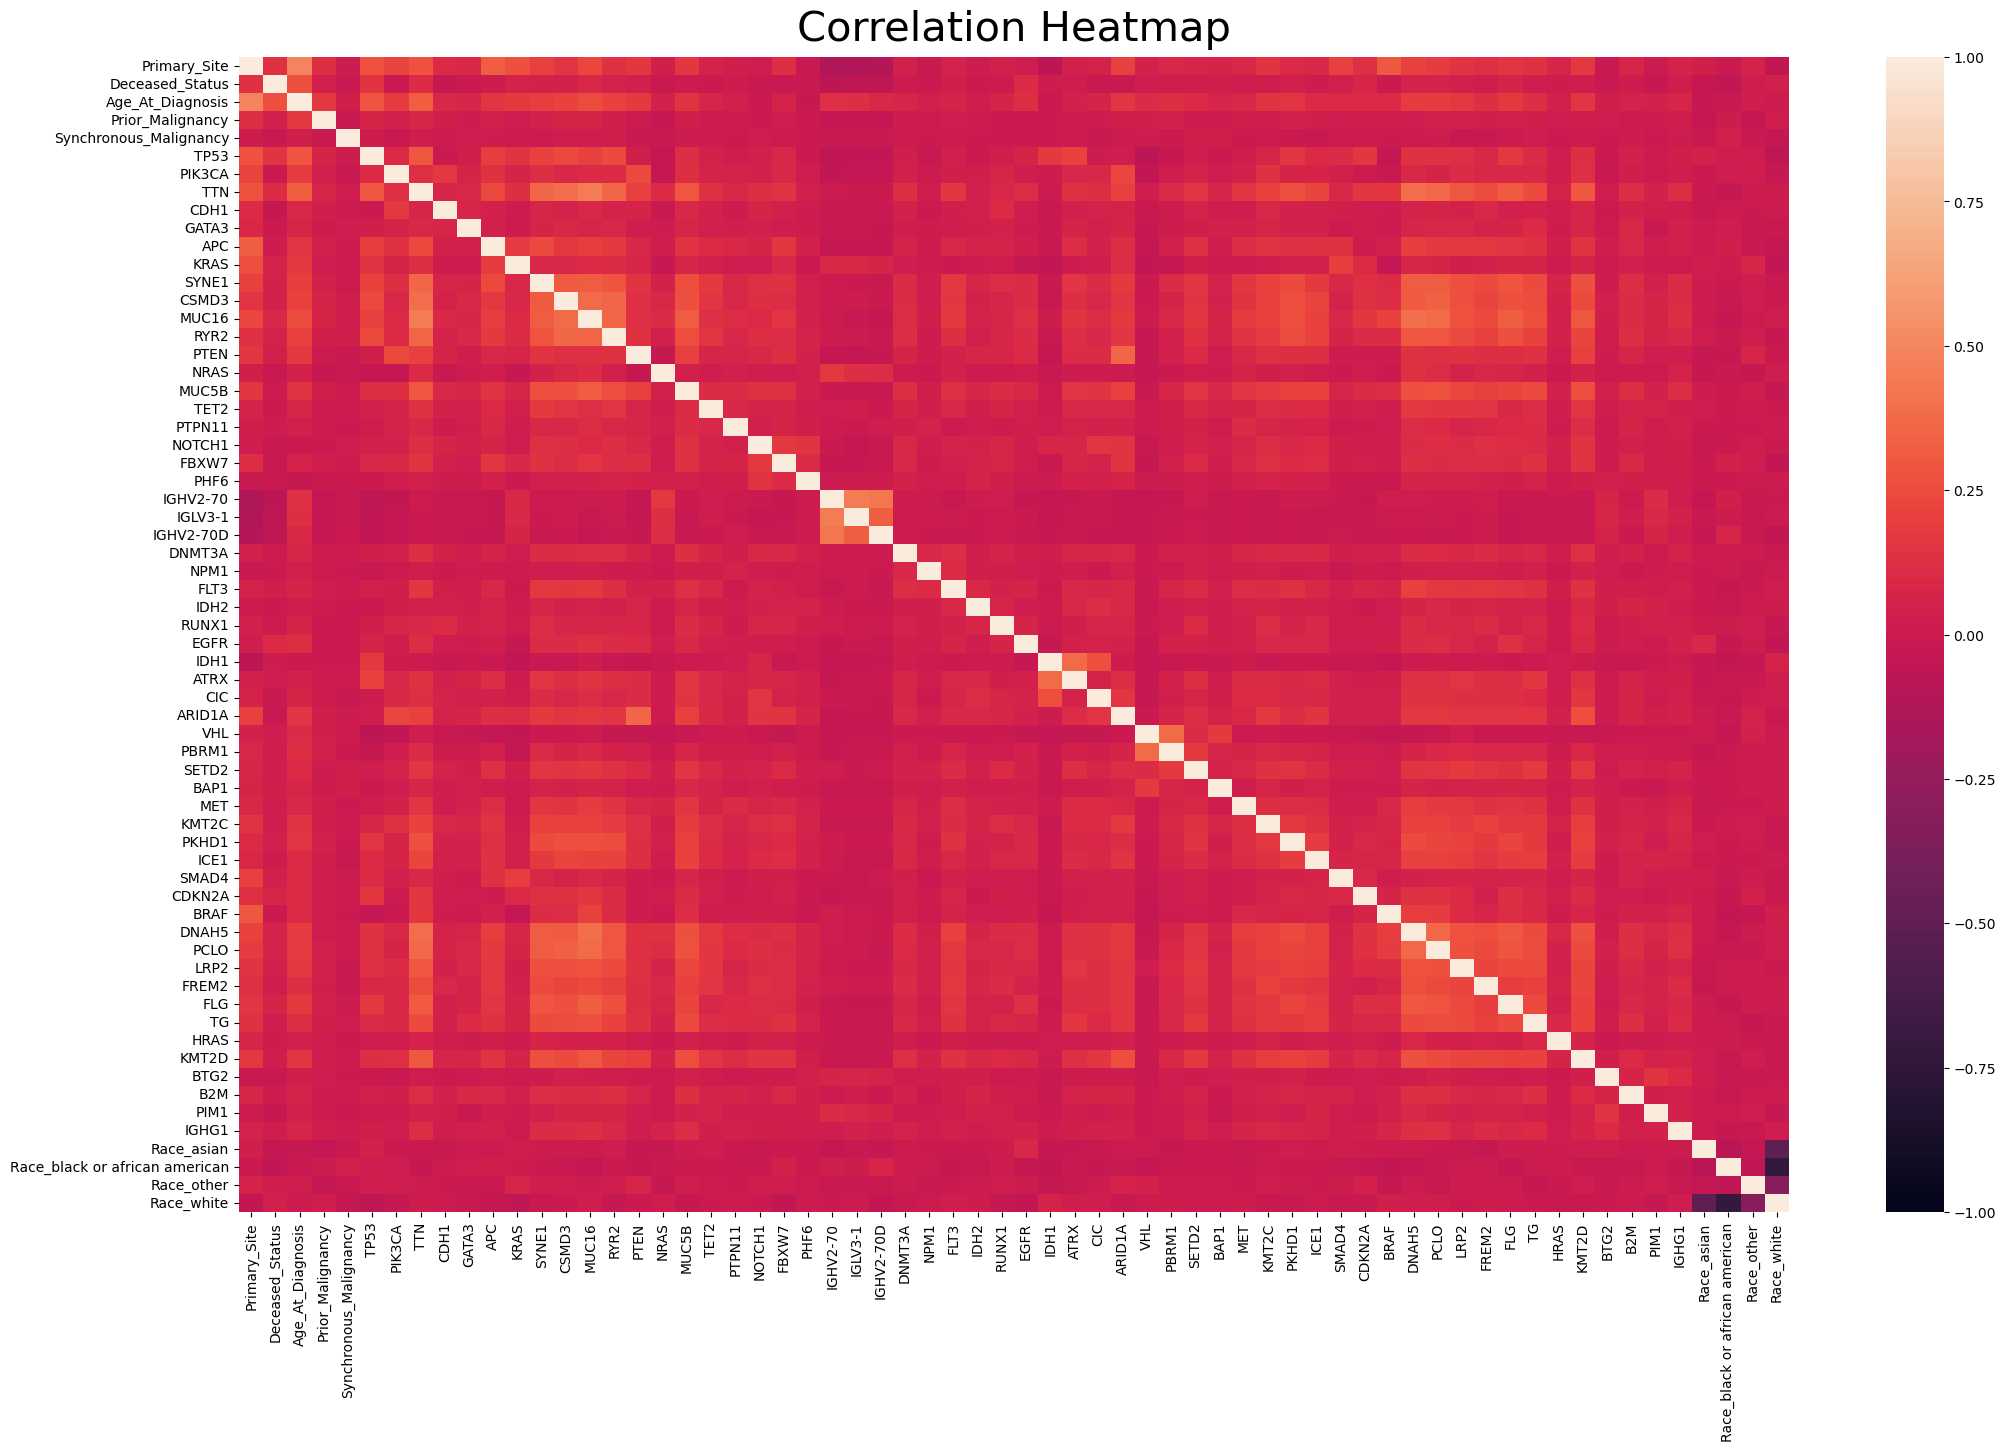

In [13]:
plt.figure(figsize=(25,15))
heatmap = sns.heatmap(final_df.corr(), vmin=-1, vmax=1, annot=False)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':30}, pad=12)

As illustrated above, the only features that exceed |0.70| in correlation are race_white and race_black, since they represented the majority of the cases' races.

## Distribution of races and ethnicities

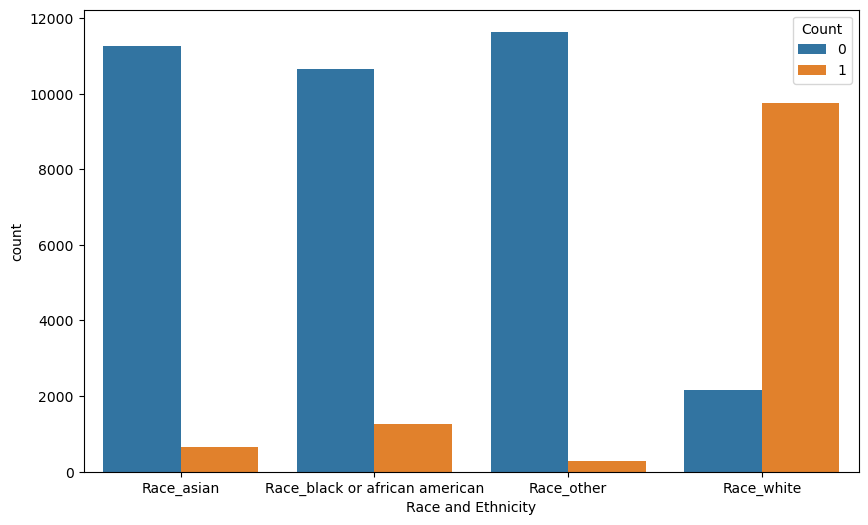

In [14]:
plt.figure(figsize=(10,6))

race_df = final_df[['Race_asian', 'Race_black or african american', 'Race_other', 'Race_white']]
race_df1 = race_df.melt(var_name='Race and Ethnicity', value_name='Count')
sns.countplot(x='Race and Ethnicity', hue='Count', data=race_df1)

plt.show()

## Distribution of ages

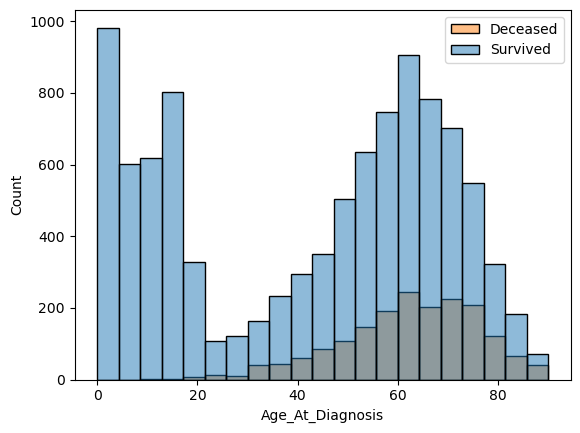

In [15]:
sns.histplot(data=final_df, x='Age_At_Diagnosis', hue='Deceased_Status')
plt.legend(labels=['Deceased', 'Survived'])
plt.show()

## Distribution of Prior Malignancies

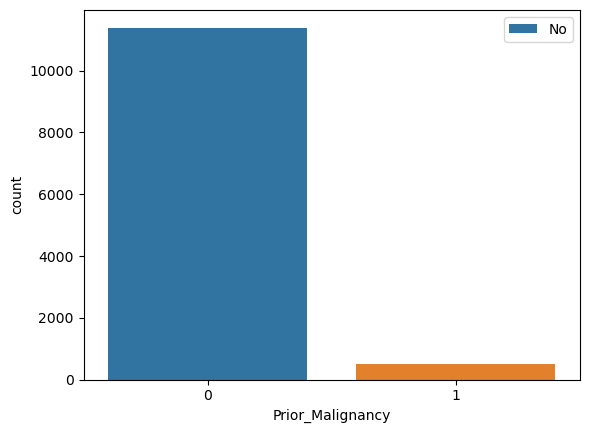

In [16]:
sns.countplot(data=final_df, x='Prior_Malignancy')
plt.legend(labels=['No', 'Yes'])
plt.show()

## Distribution of Synchronous Malignancies

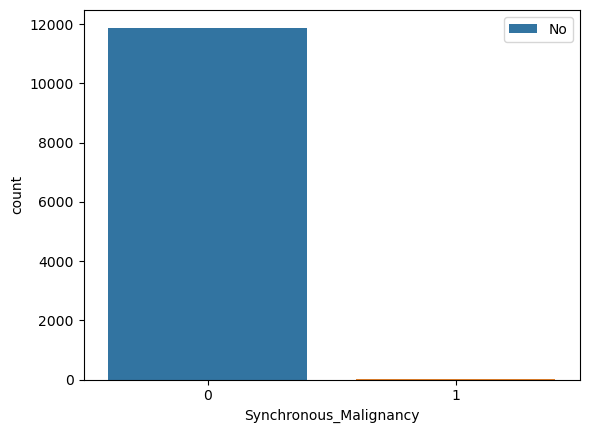

In [17]:
sns.countplot(data=final_df, x='Synchronous_Malignancy')
plt.legend(labels=['No', 'Yes'])
plt.show()